### Packages loading

In [1]:
import sys, qiskit
sys.path.insert(0, '..')
import matplotlib.pyplot as plt
import numpy as np
from qsee.compilation.qsp import QuantumStatePreparation
from qsee.core import ansatz, state, random_circuit
from qsee.backend import constant, utilities
from qsee.evolution import crossover, mutate, selection, threshold
from qsee.evolution.environment import EEnvironment, EEnvironmentMetadata
%load_ext autoreload
%autoreload 2

In [2]:
num_qubits = 3
if num_qubits == 2:
    qc_haar = state.specific(np.array([0.73042448, -0.30956267, -0.45658101,  0.40272176]))

def compilation_fitness_w(qc: qiskit.QuantumCircuit):
    qsp = QuantumStatePreparation(
        u=qc,
        target_state=state.w(num_qubits).inverse()
    ).fit(num_steps=10)
    return 1 - np.min(qsp.compiler.metrics['loss_fubini_study'])

def full_compilation_fitness_w(qc: qiskit.QuantumCircuit):
    qsp = QuantumStatePreparation(
        u=qc,
        target_state=state.w(num_qubits).inverse()
    ).fit(num_steps=100)
    return 1 - np.min(qsp.compiler.metrics['loss_fubini_study'])

In [3]:
depth = 5
num_circuit = 4
def super_evol(depth, num_circuit):
    env_metadata = EEnvironmentMetadata(
        num_qubits = num_qubits,
        depth = depth,
        num_circuit = num_circuit,
        num_generation = 50,
        prob_mutate=3/(depth * num_circuit)
    )
    env = EEnvironment(
        metadata = env_metadata,
        fitness_func=[compilation_fitness_w, full_compilation_fitness_w],
        selection_func=selection.elitist_selection,
        crossover_func=crossover.onepoint_crossover,
        mutate_func=mutate.layerflip_mutate,
        threshold_func=threshold.compilation_threshold
    )
    env.evol()
    


: 

In [8]:
compilation_fitness_w(env.circuitss[1][0])

0.23292764356939566

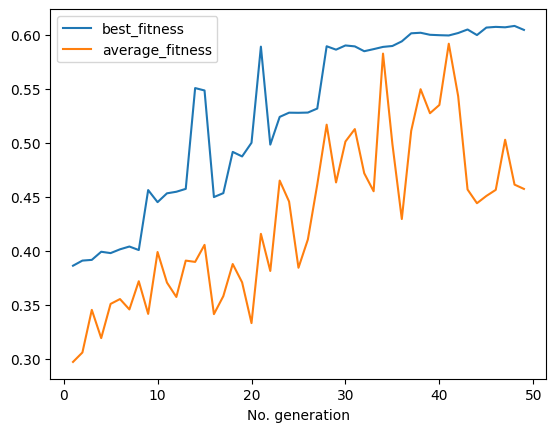

In [89]:
env.plot()

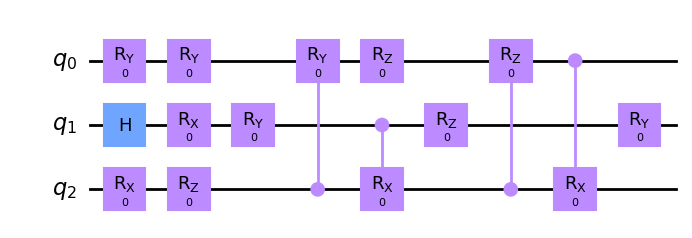

In [79]:
qc1 = random_circuit.generate_with_pool(3,3)
qc2 = random_circuit.generate_with_pool(3,3)
qc = utilities.compose_circuit([qc1, qc2])

qc = qc.assign_parameters([0]*(len(qc1.parameters) + len(qc2.parameters)))
import qiskit.quantum_info as qi
rho = qi.DensityMatrix(qc)
qc.draw('mpl')

In [52]:
env.save('test')

In [53]:
env2 = EEnvironment.load('./test', compilation_fitness_w)